In [140]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

import tensorly as tl
from tensorly.decomposition import parafac

import CP_ALS3 as cp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

In [141]:
@jit(nopython=True)
def generate_system(coo_tensor, vals, shape, mode, a, b, l2, step):
    mtx = np.zeros((a.shape[1], a.shape[1]))
    right = np.zeros((a.shape[1]))
    mask = coo_tensor[:, mode] == step
    coo_step = coo_tensor[mask]
    vals_step = vals[mask]
    
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1
        
    for i in range(a.shape[1]):
        for j in range(a.shape[1]):
            for item in range(coo_step.shape[0]):
                coord = coo_step[item]
                mtx[i, j] += (a[coord[mode_a], i] 
                              * b[coord[mode_b], i] 
                              * a[coord[mode_a], j] 
                              * b[coord[mode_b], j])
                if i == 0:
                    right[j] += a[coord[mode_a], j] * b[coord[mode_b], j] * vals_step[item]
            
            if i == j:
                mtx[i, j] += l2
    
    return mtx, right

In [147]:
@jit(nopython=True) 
def wrcp_als3(coo_tensor,
              vals,
              shape,
              rank=5,
              l2=0.5,
              max_iter=50,
              tol=1e-8):
    
    a = np.random.normal(0.0, 0.1, size=(shape[0], rank))
    b = np.random.normal(0.0, 0.1, size=(shape[1], rank))
    c = np.random.normal(0.0, 0.1, size=(shape[2], rank))
    err_arr = np.empty((max_iter, 1))  
    
    it = 0
    err1 = 1.0
    err2 = 0.0
    while np.abs(err1 - err2) > tol:
        it += 1
        
        for i in range(shape[0]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       0,
                                       b,
                                       c, 
                                       l2,
                                       i)
            
            #a[i, :] = np.linalg.pinv(A) @ right
            a[i, :] = np.linalg.solve(A, right)
         
        for j in range(shape[1]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       1,
                                       a,
                                       c, 
                                       l2,
                                       j)
            
            #b[j :] = np.linalg.pinv(A) @ right
            b[j :] = np.linalg.solve(A, right)
        
        for k in prange(shape[2]):   
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       2,
                                       a,
                                       b, 
                                       l2,
                                       k)
            
            #c[k, :] = np.linalg.pinv(A) @ right
            c[k, :] = np.linalg.solve(A, right)
    
        error = sqrt_err_relative(coo_tensor, vals, shape, a, b, c)
        err_arr[it - 1] = error
        err2 = err1
        err1 = error
        if it == max_iter:
            print("iterations over")
            break
    
    return a, b, c, err_arr, it

# Random Matrix:

In [143]:
%%time
init_shape = (7, 9, 11)
coo, vals = gen_coo_tensor(init_shape, density=0.02)
assert check_coo_tensor(coo)!= "Bad"
coo.shape[0]

CPU times: user 118 µs, sys: 2 µs, total: 120 µs
Wall time: 127 µs


13

## WRCP-ALS3:

In [153]:
%%time
max_iter = 25
rank = 3
l2 = 1e-5
a, b, c, err, it = wrcp_als3(coo, vals, init_shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Rel err = {rerror};")

Rel err = 2.454211405054028e-07;
CPU times: user 1.31 ms, sys: 0 ns, total: 1.31 ms
Wall time: 1.27 ms


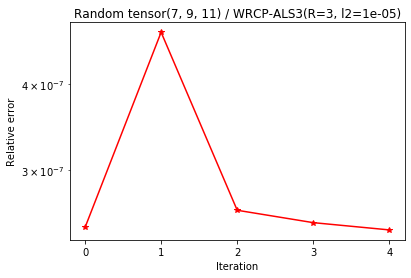

In [154]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank}, l2={l2})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

# Small Rank Matrix:

In [155]:
shape = (5, 7, 9)
rank = 3
ten = np.zeros(shape=shape)
p = np.zeros(shape=(shape[0], rank))
q = np.zeros(shape=(shape[1], rank))
r = np.zeros(shape=(shape[2], rank))
all_elem = np.prod(shape)
all_elem

315

In [156]:
p[0] = [1, 0, 0]
p[1] = [0, 1, 0]
p[2] = [0, 0, 1]

q[0] = [1, 0, 0]
q[1] = [0, 1, 0]
q[2] = [0, 0, 1]

r[0] = [1, 0, 0]
r[1] = [0, 1, 0]
r[2] = [0, 0, 1]

p[3] = [1, 1, 1]
q[3] = [1, 0, 1]
r[3] = [1, 0, 1]

p[4] = [1, 1, 1]
q[5] = [1, 0, 1]
r[6] = [1, 0, 1]
r[8] = [1, 1, 1]

In [157]:
coo = list()
vals = list()
nnz = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            temp = np.sum(p[i, :] * q[j, :] * r[k, :])
            ten[i, j, k] = temp
            if temp != 0:
                vals.append(temp)
                coo.append((i, j, k))
                nnz += 1
coo = np.array(coo)
vals = np.array(vals)
nnz

66

## Let Max_Iter = 25:

In [158]:
max_iter = 25
rank = 3

## WRCP-ALS3:

In [165]:
%%time
l2 = 1e-4
a, b, c, err, it = wrcp_als3(coo, vals, shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0025268461091489205;
CPU times: user 2.09 ms, sys: 29 µs, total: 2.12 ms
Wall time: 2.07 ms


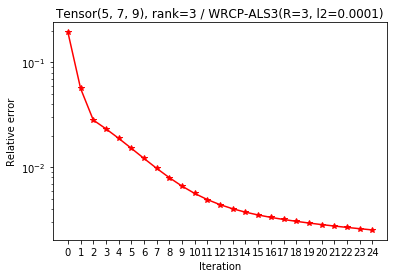

In [166]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank}, l2={l2})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

## TensorLy:

In [82]:
(w, f), err = parafac(
    tensor=ten,
    rank=rank,
    n_iter_max=max_iter,
    init="random",
    random_state=1,
    return_errors=True,
)
rerror = sqrt_err_relative(coo, vals, shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 0.0005907832440585863;


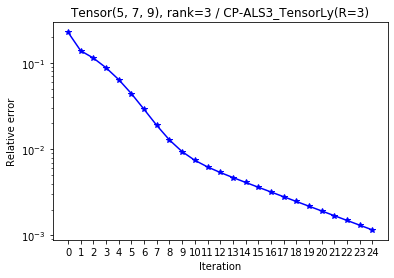

In [83]:
name = "CP-ALS3_TensorLy"
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / {name}(R={rank})")
plt.xticks(np.arange(len(err)))
plt.yscale("log")
plt.plot(np.arange(len(err)), err, 'b-*')

## CP-ALS3:

In [85]:
%%time
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0004488507741826047;
CPU times: user 4.78 ms, sys: 0 ns, total: 4.78 ms
Wall time: 4.2 ms


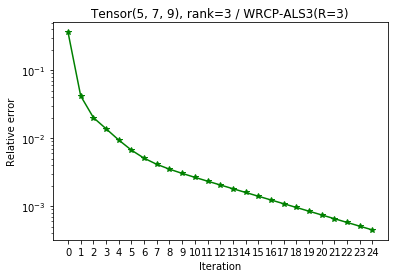

In [86]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'g-*')

## Let Max_Iter = 100:

In [87]:
max_iter = 100
rank = 3

## WRCP-ALS3:

In [105]:
%%time
l2 = 1e-4
a, b, c, err, it = wrcp_als3(coo, vals, shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.00045191841987055764;
CPU times: user 11 ms, sys: 43 µs, total: 11 ms
Wall time: 10.9 ms


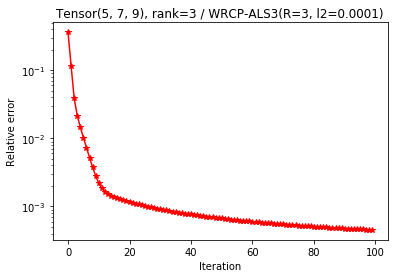

In [106]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank}, l2={l2})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

## TensorLy:

In [108]:
(w, f), err = parafac(
    tensor=ten,
    rank=rank,
    n_iter_max=max_iter,
    init="random",
    random_state=1,
    return_errors=True,
)
rerror = sqrt_err_relative(coo, vals, shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 4.690342960223186e-06;


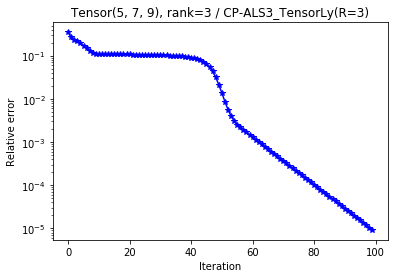

In [109]:
name = "CP-ALS3_TensorLy"
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / {name}(R={rank})")
#plt.xticks(np.arange(len(err)))
plt.yscale("log")
plt.plot(np.arange(len(err)), err, 'b-*')

## CP-ALS3:

In [114]:
%%time
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 2.7654371129513924e-07;
CPU times: user 11 ms, sys: 42 µs, total: 11 ms
Wall time: 10.6 ms


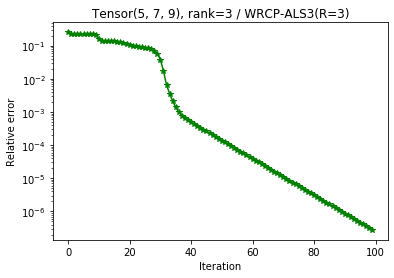

In [117]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'g-*')

## Tucker:

In [118]:
import polara.lib.hosvd as hosvd

In [138]:
%%time
core_shape = (3, 3, 3)
p, q, r, g = hosvd.tucker_als(
    idx=coo,
    val=vals,
    shape=shape,
    core_shape=core_shape,
    iters=25,
    growth_tol=0.01,
    batch_run=False,
    seed=None,
)

Step 1 of 25
growth of the core: 1.000000
Step 2 of 25
growth of the core: 0.000000
Core is no longer growing. Norm of the core: 10.099505
Done
CPU times: user 12.7 ms, sys: 10 µs, total: 12.7 ms
Wall time: 11.9 ms


In [127]:
from numba import jit

In [128]:
@jit(nopython=True) 
def sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = 0.0
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        elem = 0.0
        for p in range(a.shape[1]):
            for q in range(b.shape[1]):
                for r in range(c.shape[1]):
                    elem += g[p, q, r] * a[coord[0], p] * b[coord[1], q] * c[coord[2], r]
        
        result += (vals[item] - elem)**2  
    return np.sqrt(result)

@jit(nopython=True) 
def sqrt_err_relative_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g)        
    return result / np.sqrt((vals**2).sum())

In [139]:
rerr = sqrt_err_relative_tucker(
    coo,
    vals,
    shape,
    p,
    q,
    r,
    g,
)
print(f"Relative error = {rerr}")

Relative error = 7.967349055175334e-16
